In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import os
import re
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [22]:
TRAIN_DATA_PATH = Path("data/train")
TEST_DATA_PATH = Path("data/test")

# Set seed for reproducibility
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [23]:
# Helper function to get images within a specified range
def get_images_within_range(base_path, folder, side, start, end):
    """
    Get images from a folder that match the specified side (L/R) and layer range.
    
    Args:
        base_path: Root directory containing all folders
        folder: Name of the target folder (e.g., 'Ypktwvqjbn')
        side: Scan side to filter ('L' or 'R')
        start: Starting layer (inclusive)
        end: Ending layer (inclusive)
    """
    folder_path = base_path / folder
    
    # Get all files in the folder
    try:
        images = os.listdir(folder_path)
    except FileNotFoundError:
        return []

    # Regex pattern to extract side and layer from filenames
    pattern = re.compile(r'_([LR])_(\d{3})\.png$')
    
    selected_images = []
    
    for img_name in images:
        match = pattern.search(img_name)
        if match:
            # Extract side and layer from filename
            img_side = match.group(1)
            layer = int(match.group(2))
            
            # Check if matches criteria
            if img_side == side and start <= layer <= end:
                selected_images.append(folder_path / img_name)
    
    return sorted(selected_images)


In [24]:
def segment_roots(image_path):
    """
    Segment roots using traditional computer vision techniques.
    Returns the segmented image and binary mask.
    """
    # Load image
    image = cv2.imread(str(image_path))
    if image is None:
        return None, None
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply adaptive thresholding to identify foreground objects
    threshold = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area to eliminate noise
    min_area = 20  # Adjust based on your images
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    # Create an empty mask and draw the filtered contours
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, valid_contours, -1, 255, -1)
    
    # Apply mask to original image
    result = cv2.bitwise_and(image, image, mask=mask)
    
    return result, mask

In [25]:
def extract_features(segmented_image, mask):
    """
    Extract relevant features from segmented root images.
    """
    # Always return 14 features
    default_return = np.zeros(14)
    
    # Ensure we have a valid segmentation
    if segmented_image is None or mask is None:
        return default_return
    
    # Calculate area (proxy for volume)
    area = np.sum(mask > 0)
    
    # Calculate contours for shape analysis
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return default_return
    
    # Extract contour-based features
    try:
        all_contours = np.vstack([cnt for cnt in contours if len(cnt) > 2])
        if len(all_contours) == 0:
            return default_return
    except:
        return default_return
    
    # Calculate bounding rectangle
    x, y, w, h = cv2.boundingRect(all_contours)
    aspect_ratio = float(w) / h if h > 0 else 0
    
    # Calculate minimum enclosing circle
    try:
        _, radius = cv2.minEnclosingCircle(all_contours)
    except:
        radius = 0
    
    # Calculate contour properties
    try:
        hull = cv2.convexHull(all_contours)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area > 0 else 0
    except:
        hull_area = 0
        solidity = 0
    
    # Calculate moments
    try:
        M = cv2.moments(all_contours)
        # Avoid division by zero
        cx = M['m10'] / M['m00'] if M['m00'] != 0 else 0
        cy = M['m01'] / M['m00'] if M['m00'] != 0 else 0
        hu_moments = cv2.HuMoments(M).flatten()[:4] if M['m00'] != 0 else np.zeros(4)
    except:
        cx, cy = 0, 0
        hu_moments = np.zeros(4)
    
    # Calculate intensity features
    try:
        # Convert to grayscale if needed
        if len(segmented_image.shape) == 3:
            gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
        else:
            gray = segmented_image
            
        # Only consider non-zero pixels in the mask
        masked_pixels = gray[mask > 0]
        if len(masked_pixels) > 0:
            mean_intensity = np.mean(masked_pixels)
            std_intensity = np.std(masked_pixels)
            min_intensity = np.min(masked_pixels)
            max_intensity = np.max(masked_pixels)
        else:
            mean_intensity = 0
            std_intensity = 0
            min_intensity = 0
            max_intensity = 0
    except:
        mean_intensity = 0
        std_intensity = 0
        min_intensity = 0
        max_intensity = 0
    
    # Combine all features
    features = np.array([
        area,
        len(contours),  # Number of root segments
        aspect_ratio,
        w * h,  # Bounding rectangle area
        radius,
        hull_area,
        solidity,
        mean_intensity,
        std_intensity,
        min_intensity,
        max_intensity,
        *hu_moments  # Unpack the first 4 Hu moments
    ])
    
    # Make sure we return exactly 14 features 
    if len(features) != 14:
        print(f"Warning: Expected 14 features, got {len(features)}")
        return default_return
    
    return features

In [26]:
def process_image_range(base_path, folder, side, start, end):
    """
    Process all images in the specified range and extract combined features.
    """
    # Get images for the specified range
    images_in_range = get_images_within_range(base_path, folder, side, start, end)
    
    if not images_in_range:
        return np.zeros(28)  # Return zero features if no images found
    
    all_features = []
    expected_length = 14  # Expected length of the feature vector
    
    for img_path in images_in_range:
        # Segment the image using our custom function
        try:
            segmented_img, mask = segment_roots(img_path)
            
            if segmented_img is not None and mask is not None:
                # Extract features from the segmented image
                features = extract_features(segmented_img, mask)
                
                # Ensure consistent feature length
                if len(features) == expected_length:
                    all_features.append(features)
        except Exception as e:
            pass  # Skip problematic images
    
    if not all_features:
        return np.zeros(28)
    
    # Calculate aggregate statistics across all images
    try:
        all_features = np.array(all_features)
        
        # Return mean, max of each feature
        feature_means = np.mean(all_features, axis=0)
        feature_maxes = np.max(all_features, axis=0)
        
        # Combine all aggregate features
        combined_features = np.concatenate([feature_means, feature_maxes])
        
        return combined_features
    except ValueError:
        # If there's still an issue with inconsistent feature lengths
        print(f"Warning: Inconsistent feature lengths detected for {folder}, {side}, {start}-{end}")
        return np.zeros(28)  # Return zero features as a fallback

In [27]:
class RootVolumeDataset(Dataset):
    def __init__(self, df, base_path, is_train=True):
        self.df = df
        self.base_path = base_path
        self.is_train = is_train
        self.features = self._precompute_features()
        
    def _precompute_features(self):
        """Precompute features for all samples."""
        all_features = []
        
        for _, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Extracting features"):
            features = process_image_range(
                self.base_path,
                row["FolderName"],
                row["Side"],
                row["Start"],
                row["End"]
            )
            all_features.append(features)
            
        return np.array(all_features)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        
        if self.is_train:
            label = self.df['RootVolume'].iloc[idx]
            return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
        
        return torch.tensor(features, dtype=torch.float32)


In [28]:
class RootVolumeRegressor(nn.Module):
    def __init__(self, input_size):
        super(RootVolumeRegressor, self).__init__()
        
        # Define a simple MLP
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)


Loading data...
Train data shape: (386, 9)
Test data shape: (130, 8)
Creating datasets...


Extracting features:   0%|          | 0/386 [00:00<?, ?it/s]

Extracting features:   5%|▍         | 19/386 [00:00<00:01, 183.74it/s]

Extracting features:  17%|█▋        | 65/386 [00:00<00:01, 190.53it/s]

Extracting features:  30%|██▉       | 114/386 [00:00<00:01, 217.09it/s]

Extracting features:  44%|████▎     | 168/386 [00:00<00:00, 238.88it/s]

Extracting features:  57%|█████▋    | 221/386 [00:00<00:00, 246.97it/s]

Extracting features:  70%|███████   | 272/386 [00:01<00:00, 247.83it/s]

Extracting features:  86%|████████▌ | 332/386 [00:01<00:00, 273.92it/s]

Extracting features: 100%|██████████| 386/386 [00:01<00:00, 247.04it/s]


Extracting features:   0%|          | 0/130 [00:00<?, ?it/s]

Extracting features:  15%|█▌        | 20/130 [00:00<00:00, 191.10it/s]

Extracting features:  32%|███▏      | 41/130 [00:00<00:00, 197.44it/s]

Extracting features:  47%|████▋     | 61/130 [00:00<00:00, 189.88it/s]

Extracting features:  64%|██████▍   | 83/130 [00:00<00:00, 199.68it/s]

Extracting features:  83%|████████▎ | 108/130 [00:00<00:00, 215.41it/s]

Extracting features: 100%|██████████| 130/130 [00:00<00:00, 210.23it/s]


Using device: cpu
Model initialized with input size: 28
Starting training...
Epoch [1/100], Train Loss: 7.1645, Val Loss: 5.4977, Val RMSE: 2.3526
Epoch [2/100], Train Loss: 6.5680, Val Loss: 5.0870, Val RMSE: 2.2634
Epoch [3/100], Train Loss: 5.7640, Val Loss: 4.0002, Val RMSE: 2.0086
Epoch [4/100], Train Loss: 4.2051, Val Loss: 2.3122, Val RMSE: 1.5303
Epoch [5/100], Train Loss: 2.7939, Val Loss: 1.8934, Val RMSE: 1.3846
Epoch [6/100], Train Loss: 2.4849, Val Loss: 1.8388, Val RMSE: 1.3650
Epoch [7/100], Train Loss: 2.5613, Val Loss: 1.8149, Val RMSE: 1.3566
Epoch [8/100], Train Loss: 2.5104, Val Loss: 1.8463, Val RMSE: 1.3677
Epoch [9/100], Train Loss: 2.5033, Val Loss: 1.8224, Val RMSE: 1.3592
Epoch [10/100], Train Loss: 2.5671, Val Loss: 1.8256, Val RMSE: 1.3603
Epoch [11/100], Train Loss: 2.5452, Val Loss: 1.8285, Val RMSE: 1.3614
Epoch [12/100], Train Loss: 2.6905, Val Loss: 1.8179, Val RMSE: 1.3576
Epoch [13/100], Train Loss: 2.6373, Val Loss: 1.8267, Val RMSE: 1.3607
Epoch [14

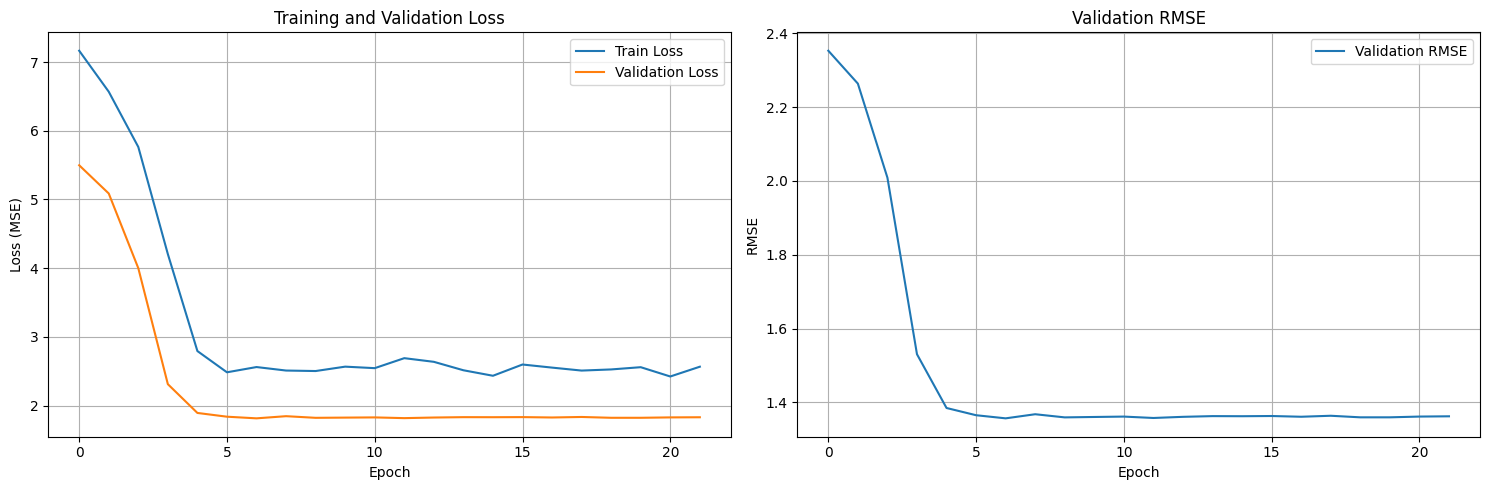

In [29]:
def main():
    print("Loading data...")
    # Load datasets
    train_df = pd.read_csv("Train.csv")
    test_df = pd.read_csv("Test.csv")
    submission_df = pd.read_csv("Sample_Submission.csv")
    
    print(f"Train data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    
    print("Creating datasets...")
    # Create datasets
    train_dataset = RootVolumeDataset(train_df, TRAIN_DATA_PATH, is_train=True)
    test_dataset = RootVolumeDataset(test_df, TEST_DATA_PATH, is_train=False)
    
    # Split training data into train and validation sets
    train_idx, val_idx = train_test_split(
        np.arange(len(train_dataset)),
        test_size=0.2,
        random_state=42
    )
    
    # Create subset datasets
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    # Create dataloaders
    train_dataloader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_subset, batch_size=16, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create model
    input_size = train_dataset.features.shape[1]  # Get feature dimension
    model = RootVolumeRegressor(input_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    print(f"Model initialized with input size: {input_size}")
    
    # Training loop
    print("Starting training...")
    num_epochs = 100
    best_loss = float('inf')
    early_stop_patience = 15
    no_improve_count = 0
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': []
    }
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        
        for features, targets in train_dataloader:
            features, targets = features.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_dataloader)
        history['train_loss'].append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for features, targets in val_dataloader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
        
        val_loss /= len(val_dataloader)
        val_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        
        history['val_loss'].append(val_loss)
        history['val_rmse'].append(val_rmse)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}')
        
        # Early stopping
        if no_improve_count >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Plot training history if matplotlib is available
    try:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(history['val_rmse'], label='Validation RMSE')
        plt.title('Validation RMSE')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        print("Training history plot saved to 'training_history.png'")
    except:
        print("Could not create training history plot")
    
    print("Making predictions on test set...")
    # Load best model
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    
    # Generate predictions for test set
    test_preds = []
    
    with torch.no_grad():
        for features in test_dataloader:
            features = features.to(device)
            outputs = model(features).squeeze()
            test_preds.extend(outputs.cpu().numpy())
    
    # Create submission file
    submission = test_df[['ID']].copy()
    submission['RootVolume'] = test_preds
    submission.to_csv('submission.csv', index=False)
    print("Submission file created!")
    print(submission.head())

if __name__ == "__main__":
    main()